<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

**Импорты:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


from statsmodels.tsa.seasonal import seasonal_decompose

from time import time

In [2]:
RANDOM_STATE = 12345

In [3]:
import warnings
warnings.filterwarnings("ignore")

**Данные**

In [4]:
data = pd.read_csv("/datasets/taxi.csv")

In [5]:
display(data.head(3))

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


In [6]:
display(data.tail(3))

,datetime,num_orders
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [7]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

In [8]:
display(data.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
print("Кол-во дупликатов:",data.duplicated().sum())

Кол-во дупликатов: 0


In [10]:
print("Кол-во пропусков:")
display(data.isna().sum())

Кол-во пропусков:


datetime      0
num_orders    0
dtype: int64

In [11]:
data["datetime"] = pd.to_datetime(data["datetime"], format='%Y-%m-%d %H:%M:%S')
data["datetime"] = data["datetime"].sort_values().reset_index(drop=True)

In [12]:
data = data.set_index(["datetime"]).resample('1H').sum()

**Вывод:**

- Данные и типы данных соответсвуют описанию;
- Дубликаты отсутствуют;
- Пропуски отсутствуют;
- Данные подготовненны к анализу. 

## Анализ

**Тренды** 

In [13]:
decomposed = seasonal_decompose(data)

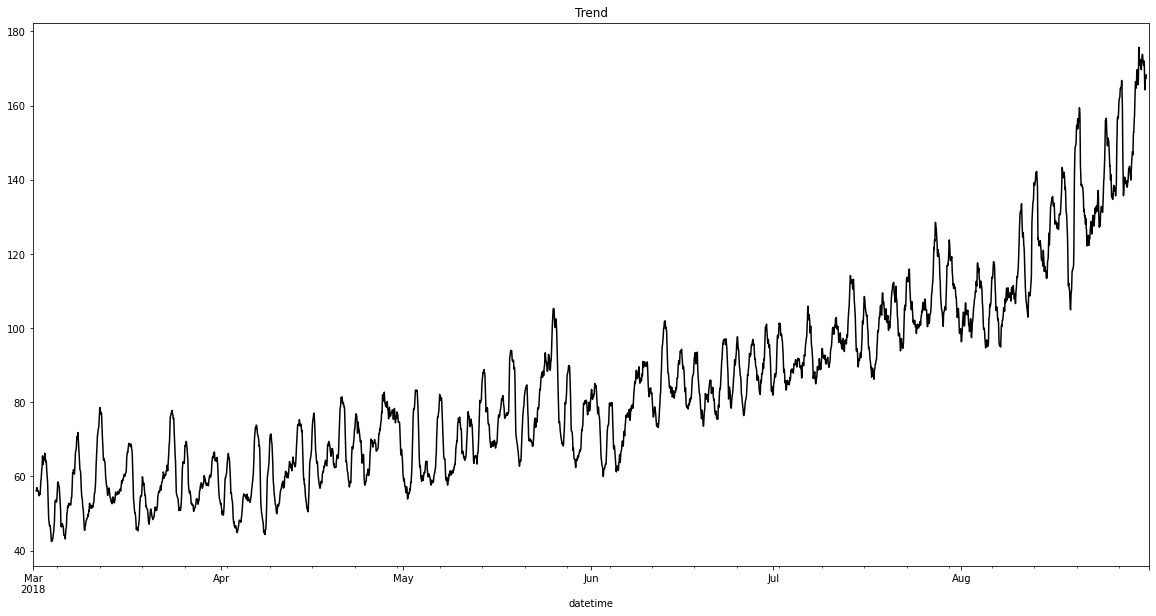

In [14]:
plt.figure(figsize=(20,10))
decomposed.trend.plot(ax=plt.gca(), color="black")
plt.title('Trend')
plt.show()

**Вывод:**

Из графика видно, что количество заказов постепенно растет на протяжении всего времени. 

**Сезонность** 

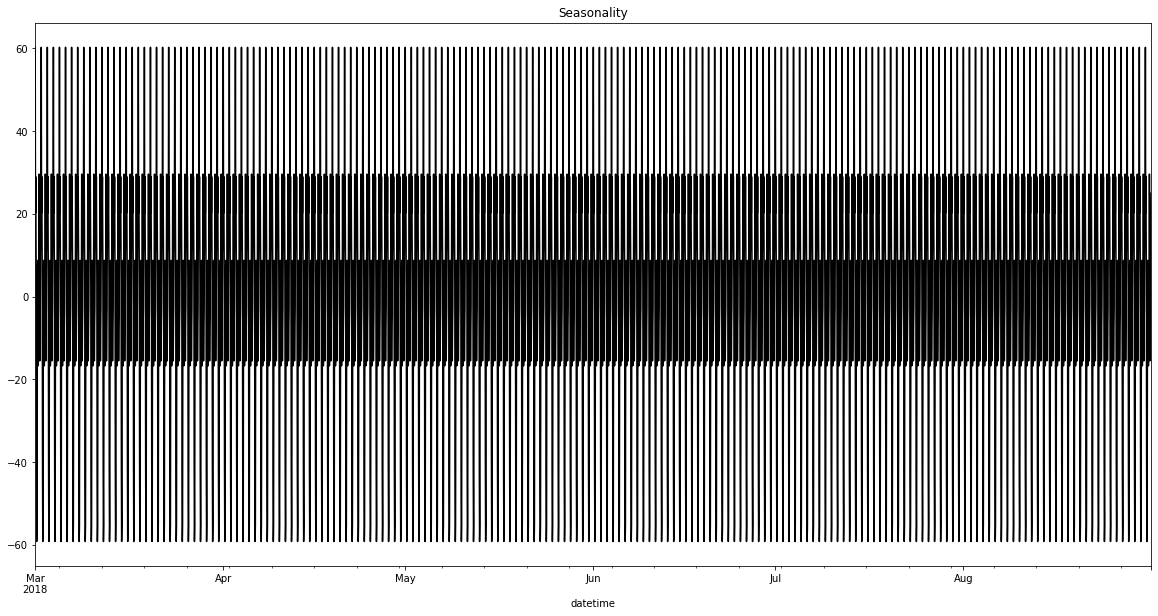

In [15]:
plt.figure(figsize=(20,10))
decomposed.seasonal.plot(ax=plt.gca(), color="black")
plt.title('Seasonality')
plt.show()

Данные не разборчивы, посмотрим на 7 дневные вырезки: 

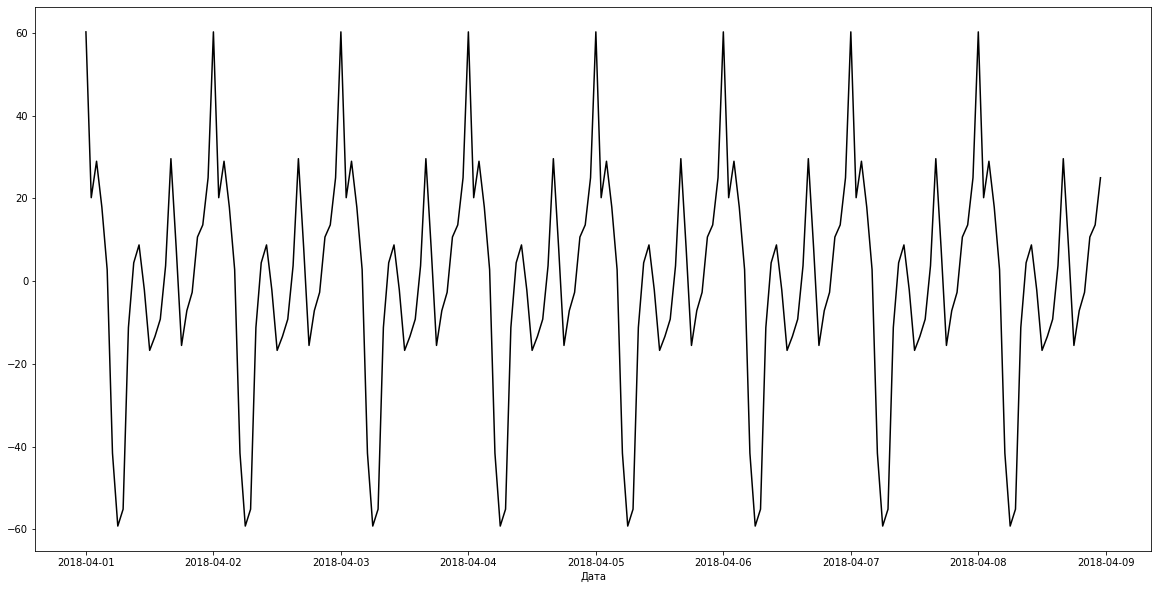

In [16]:
plt.figure(figsize=(20,10))
plt.plot(decomposed.seasonal['2018-04-01':'2018-04-08'], color="black")
plt.xlabel("Дата")
plt.show()

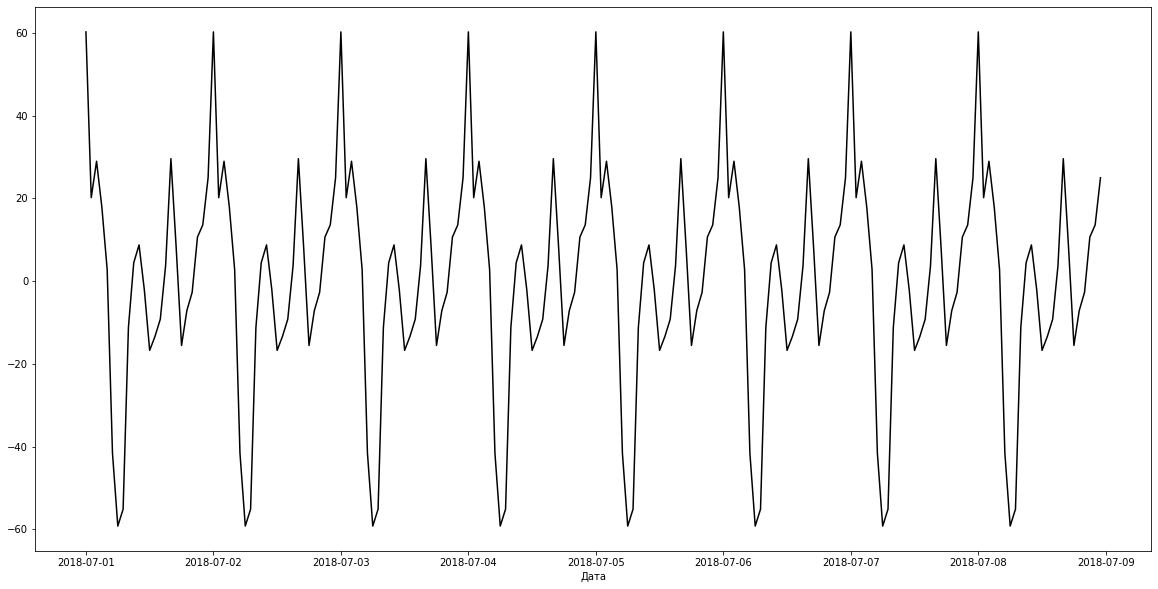

In [17]:
plt.figure(figsize=(20,10))
plt.plot(decomposed.seasonal['2018-07-01':'2018-07-08'], color="black")
plt.xlabel("Дата")
plt.show()

**Вывод:**

- Минимальное количество заказов - утром
- Максимальное количество заказов - вечером
- Присутствует сезонность с периодом в 1 день

**Декомпозиция** 

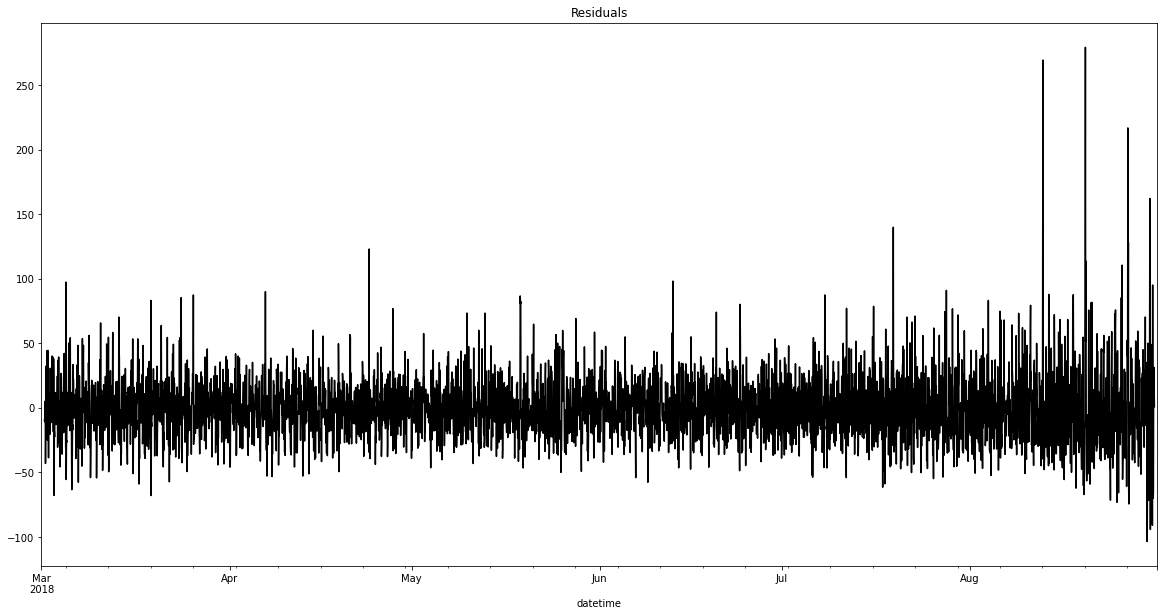

In [18]:
plt.figure(figsize=(20,10))
decomposed.resid.plot(ax=plt.gca(), color="black")
plt.title('Residuals')
plt.show()

**Скользящее среднее**

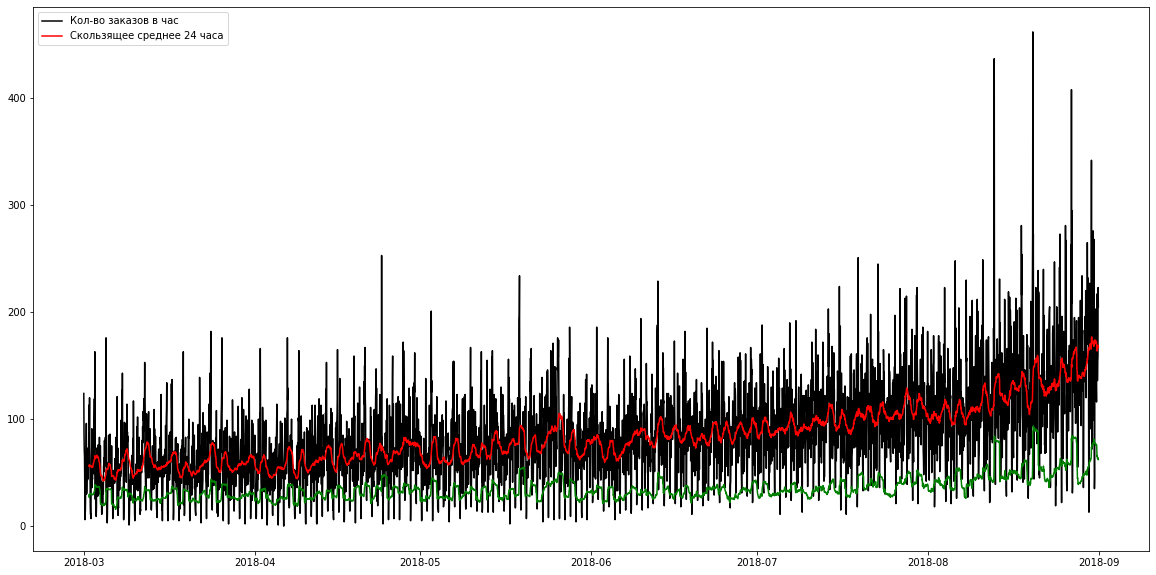

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(data, color="black")
plt.plot(data.rolling(24).mean(), color="red")
plt.plot(data.rolling(24).std(), color='green')
plt.legend(["Кол-во заказов в час", "Скользящее среднее 24 часа"])
plt.show()

**Вывод:**

В начале данные стационарны, в период с 2018-03 по 2018-08. после, данные становятся нестационарными. Это может плохо повлиять на обучение.

## Обучение

Функция для создания признаков: 

In [20]:
def features(data,lag,rolling):
    data["hour"] = data.index.hour
    data["dayofweek"] = data.index.dayofweek
    
    for lag in range(1, lag+1):
            data["lag_{}".format(lag)] = data["num_orders"].shift(lag)
       
    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling).mean()

Создадим признаки:

In [21]:
features(data, 24, 24)

Создадим две выборки, тренировочная и тестовая: 

In [22]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()

In [23]:
data

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


Проверим: 

In [23]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Разделим данные на признаки и на целевой признак: 

In [24]:
features_train = train.drop("num_orders", axis=1)
features_test = test.drop("num_orders", axis=1)

target_train = train["num_orders"]
target_test = test["num_orders"]

Проверим: 

In [25]:
print("Размер features_test:",features_test.shape)
print("Размер features_train:",features_train.shape)
print("Размер target_test:",target_test.shape)
print("Размер target_train:",target_train.shape)

Размер features_test: (442, 27)
Размер features_train: (3950, 27)
Размер target_test: (442,)
Размер target_train: (3950,)


Для анализа моделей: 

In [26]:
models_result = pd.DataFrame(columns = ["RMSE","TrainTime","PredictionTime"],
                             index = ["LinearRegression_auto",
                                      "RandomForestRegressor_friedman_mse","RandomForestRegressor_poisson",
                                      "DecisionTreeRegressor_friedman_mse","DecisionTreeRegressor_poisson",
                                      "LGBMRegressor_gbdt","LGBMRegressor_dart",
                                      "CatBoostRegressor_SymmetricTree","CatBoostRegressor_Depthwise",
                                      "CatBoostRegressor_Lossguide"])

In [27]:
def rmse(predict,true):
    square_distance = (np.array(predict) - np.array(true)) ** 2
    mean_square_distance = square_distance.mean()
    return np.sqrt(mean_square_distance)

In [28]:
def score_print(predicted,true):
    print("RMSE:",round(rmse(predicted,true),2))
    return round(rmse(predicted,true),2)

**LinearRegression_auto**

In [29]:
%%time
start_time = time()

model = LinearRegression()
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["LinearRegression_auto"] = score_print(predicted,target_train)
models_result["TrainTime"]["LinearRegression_auto"] = round(train_time - start_time,2)
models_result["PredictionTime"]["LinearRegression_auto"] = round(prediction_time - train_time,2)

RMSE: 25.84
CPU times: user 52.3 ms, sys: 36.6 ms, total: 88.9 ms
Wall time: 76.9 ms


**RandomForestRegressor_friedman_mse**

In [30]:
%%time
start_time = time()

model = RandomForestRegressor(criterion="friedman_mse",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["RandomForestRegressor_friedman_mse"] = score_print(predicted,target_train)
models_result["TrainTime"]["RandomForestRegressor_friedman_mse"] = round(train_time - start_time,2)
models_result["PredictionTime"]["RandomForestRegressor_friedman_mse"] = round(prediction_time - train_time,2)

RMSE: 8.51
CPU times: user 5.42 s, sys: 70 ms, total: 5.49 s
Wall time: 5.51 s


**RandomForestRegressor_poisson**

In [31]:
%%time
start_time = time()

model = RandomForestRegressor(criterion="poisson",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["RandomForestRegressor_poisson"] = score_print(predicted,target_train)
models_result["TrainTime"]["RandomForestRegressor_poisson"] = round(train_time - start_time,2)
models_result["PredictionTime"]["RandomForestRegressor_poisson"] = round(prediction_time - train_time,2)

RMSE: 10.22
CPU times: user 44.4 s, sys: 114 ms, total: 44.5 s
Wall time: 44.6 s


**DecisionTreeRegressor_friedman_mse**

In [32]:
%%time
start_time = time()

model = DecisionTreeRegressor(criterion="friedman_mse",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["DecisionTreeRegressor_friedman_mse"] = score_print(predicted,target_train)
models_result["TrainTime"]["DecisionTreeRegressor_friedman_mse"] = round(train_time - start_time,2)
models_result["PredictionTime"]["DecisionTreeRegressor_friedman_mse"] = round(prediction_time - train_time,2)

RMSE: 0.0
CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 107 ms


**DecisionTreeRegressor_poisson**

In [33]:
%%time
start_time = time()

model = DecisionTreeRegressor(criterion="poisson",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["DecisionTreeRegressor_poisson"] = score_print(predicted,target_train)
models_result["TrainTime"]["DecisionTreeRegressor_poisson"] = round(train_time - start_time,2)
models_result["PredictionTime"]["DecisionTreeRegressor_poisson"] = round(prediction_time - train_time,2)

RMSE: 0.01
CPU times: user 766 ms, sys: 45 µs, total: 766 ms
Wall time: 777 ms


**LGBMRegressor_gbdt**

In [34]:
%%time
start_time = time()

model = LGBMRegressor(boosting_type="gbdt",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["LGBMRegressor_gbdt"] = score_print(predicted,target_train)
models_result["TrainTime"]["LGBMRegressor_gbdt"] = round(train_time - start_time,2)
models_result["PredictionTime"]["LGBMRegressor_gbdt"] = round(prediction_time - train_time,2)

RMSE: 12.13
CPU times: user 3min 10s, sys: 4.55 s, total: 3min 14s
Wall time: 3min 15s


**LGBMRegressor_dart**

In [35]:
%%time
start_time = time()

model = LGBMRegressor(boosting_type="dart",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["LGBMRegressor_dart"] = score_print(predicted,target_train)
models_result["TrainTime"]["LGBMRegressor_dart"] = round(train_time - start_time,2)
models_result["PredictionTime"]["LGBMRegressor_dart"] = round(prediction_time - train_time,2)

RMSE: 17.97
CPU times: user 2min 44s, sys: 3.45 s, total: 2min 47s
Wall time: 2min 49s


**CatBoostRegressor_SymmetricTree**

In [36]:
%%time
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="SymmetricTree",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["CatBoostRegressor_SymmetricTree"] = score_print(predicted,target_train)
models_result["TrainTime"]["CatBoostRegressor_SymmetricTree"] = round(train_time - start_time,2)
models_result["PredictionTime"]["CatBoostRegressor_SymmetricTree"] = round(prediction_time - train_time,2)

RMSE: 10.9
CPU times: user 7.14 s, sys: 145 ms, total: 7.29 s
Wall time: 8.14 s


**CatBoostRegressor_Depthwise**

In [37]:
%%time
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="Depthwise",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["CatBoostRegressor_Depthwise"] = score_print(predicted,target_train)
models_result["TrainTime"]["CatBoostRegressor_Depthwise"] = round(train_time - start_time,2)
models_result["PredictionTime"]["CatBoostRegressor_Depthwise"] = round(prediction_time - train_time,2)

RMSE: 8.0
CPU times: user 18.5 s, sys: 154 ms, total: 18.6 s
Wall time: 19.7 s


**CatBoostRegressor_Lossguide**

In [38]:
%%time
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="Lossguide",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_train)
prediction_time = time()

models_result["RMSE"]["CatBoostRegressor_Lossguide"] = score_print(predicted,target_train)
models_result["TrainTime"]["CatBoostRegressor_Lossguide"] = round(train_time - start_time,2)
models_result["PredictionTime"]["CatBoostRegressor_Lossguide"] = round(prediction_time - train_time,2)

RMSE: 7.9
CPU times: user 16.3 s, sys: 117 ms, total: 16.4 s
Wall time: 17.5 s


In [39]:
display(models_result)

,RMSE,TrainTime,PredictionTime
LinearRegression_auto,25.84,0.01,0.07
RandomForestRegressor_friedman_mse,8.51,5.43,0.08
RandomForestRegressor_poisson,10.22,44.43,0.21
DecisionTreeRegressor_friedman_mse,0.0,0.1,0.0
DecisionTreeRegressor_poisson,0.01,0.77,0.0
LGBMRegressor_gbdt,12.13,195.83,0.1
LGBMRegressor_dart,17.97,169.1,0.09
CatBoostRegressor_SymmetricTree,10.9,8.14,0.01
CatBoostRegressor_Depthwise,8.0,19.58,0.08
CatBoostRegressor_Lossguide,7.9,17.37,0.09


**Вывод:**

*Примечание - данные "DecisionTreeRegressor_friedman_mse" и "DecisionTreeRegressor_poisson" проигнорированы из-за нереалистичных результатов.*

- Самая быстрая модель по обучению - LinearRegression_auto
- Самая быстрая модель по предсказанию - CatBoostRegressor_SymmetricTree
- Самая быстрая модель с хорошим качеством (RMSE < 20) - RandomForestRegressor_friedman_mse
- Самая качественная модель - CatBoostRegressor_Lossguide
- Лучшая модель по время.качество - RandomForestRegressor_friedman_mse
- Самая медленная модель по обучению - LGBMRegressor_gbdt
- Самая медленная модель по предсказанию - RandomForestRegressor_poisson
- Самая не качественная модель - LinearRegression_auto

## Тестирование

Тестирование модели - CatBoostRegressor_Depthwise как лучшая модель по время.качество

In [40]:
%%time

model = CatBoostRegressor(logging_level="Silent",grow_policy="Depthwise",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted = model.predict(features_test)

models_result["RMSE"]["CatBoostRegressor_Depthwise"] = score_print(predicted,target_test)

RMSE: 40.42
CPU times: user 19.1 s, sys: 150 ms, total: 19.3 s
Wall time: 20.4 s


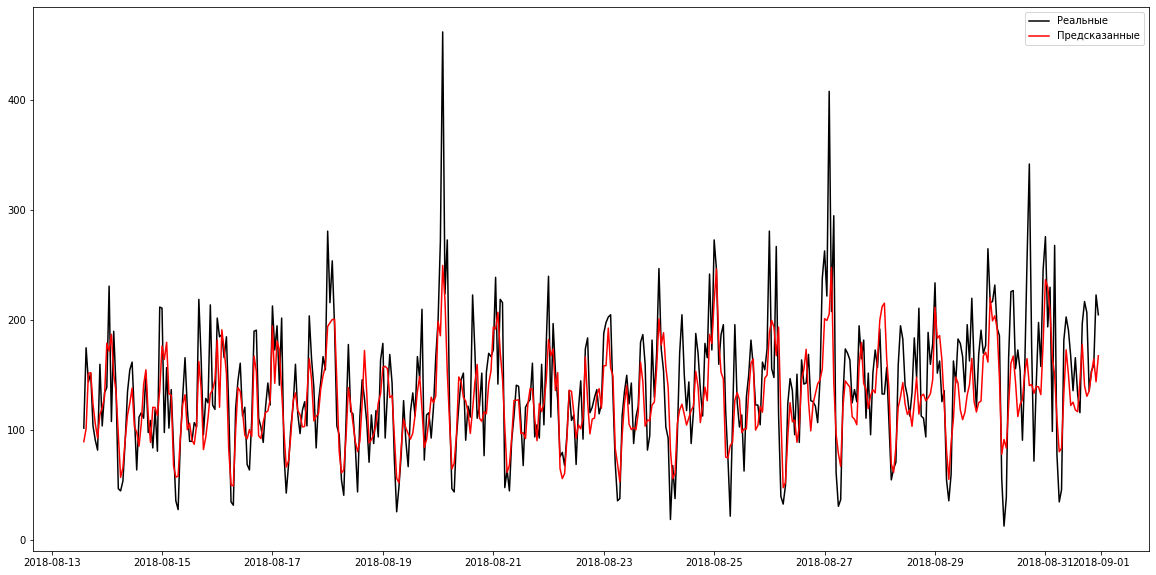

In [41]:
predicted = pd.DataFrame(predicted, index=features_test.index)
plt.figure(figsize=(20,10))
plt.plot(target_test, color="black")
plt.plot(predicted, color="red")
plt.legend(["Реальные","Предсказанные"])
plt.show()

**Вывод:**

RMSE модели равен 40.5 (что не больше 48) однако по графику видно, что модель тенденцию предсказывает, но ошибается в пиковых значениях. Это приведет к тому, что модель будет часто недооценивать количество заказов, что приведет к нехватке водителей в пиковой нагрузке. 